# SPU基础

> 以下代码仅作为示例，请勿在生产环境直接使用。

SPU设备在SecretFlow中负责执行MPC计算。

本教程将帮助你：

- 熟悉SPU设备和SPU Object。
- 学习如何在Python Object/PYU Object和SPU Object之间相互转化。
- 利用SPU设备执行MPC计算。

## 创建一个SPU设备

### 创建SecretFlow Parties

SecretFlow Parties是在SecretFlow的基本节点，我们将会创建4个party - **alice**, **bob**, **carol** 和 **dave**。

基于这四个party，我们将会建立3个设备。

- 一个基于 *alice* 的PYU设备
- 一个基于 *dave* 的PYU设备
- 一个基于 *alice* , *bob* 和 *carol* 的SPU设备



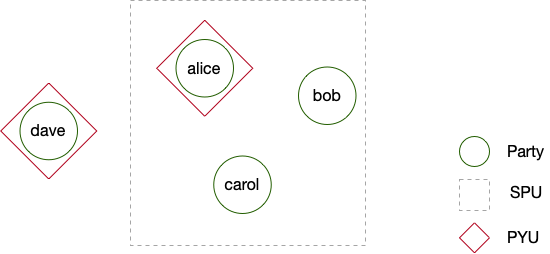

In [1]:
import secretflow as sf
# Check the version of your SecretFlow
print('The version of SecretFlow: {}'.format(sf.__version__))
# In case you have a running secretflow runtime already.
sf.shutdown()
sf.init(['alice', 'bob', 'carol', 'dave'], address='local')

The version of SecretFlow: 1.4.0b0


2024-04-09 13:17:13,440	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


### 创建一个基于三方ABY3协议的SPU设备

之后，我们创建一个基于 [ABY3](https://eprint.iacr.org/2018/403.pdf) 协议的SPU设备。

`sf.utils.testing.cluster_def` 是一个helper通过寻找未占用的端口来创建一个设置。

In [2]:
aby3_config = sf.utils.testing.cluster_def(parties=['alice', 'bob', 'carol'])
aby3_config

{'nodes': [{'party': 'alice', 'address': '127.0.0.1:36911'},
  {'party': 'bob', 'address': '127.0.0.1:35457'},
  {'party': 'carol', 'address': '127.0.0.1:38207'}],
 'runtime_config': {'protocol': 3, 'field': 3}}

随后我们用 *aby3_config* 来创建一个SPU设备并检查其 cluster_def 。

In [3]:
spu_device = sf.SPU(aby3_config)
spu_device.cluster_def

{'nodes': [{'party': 'alice', 'address': '127.0.0.1:36911'},
  {'party': 'bob', 'address': '127.0.0.1:35457'},
  {'party': 'carol', 'address': '127.0.0.1:38207'}],
 'runtime_config': {'protocol': 3, 'field': 3}}

最后，我们创建两个PYU设备。

In [4]:
alice, dave = sf.PYU('alice'), sf.PYU('dave')

## 向SPU设备传值

在讨论利用SPU设备计算之前，我们需要理解如何将一个 Python object / PYUObject 传给一个SPU设备。

### SPUObject

PYU Object可以转化到 SPU Object被SPU节点来共享秘密。

**sf.device.SPUIO** 是执行该任务的辅助类。您不需要在代码中调用此方法。我们只是使用它来向你演示SPUObjects的结构和发生的一切。

每一个SPUObject包含两个成员：

- meta: 原始对象的结构。
- shares: 原始对象的秘密分享。

In [5]:
spu_io = sf.device.SPUIO(spu_device.conf, spu_device.world_size)
bank_account = [{'id': 12345, 'deposit': 1000.25}, {'id': 12345, 'deposit': 100000.25}]
import spu
meta, io_info, *shares = spu_io.make_shares(bank_account, spu.Visibility.VIS_SECRET)

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
INFO:jax._src.xla_bridge:Unable to initialize backend 'plugin': xla_extension has no attributes named get_plugin_device_client. Compile TensorFlow with //tensorflow/compiler/xla/python:enable_plugin_device set to true (defaults to false) to enable this.


In [6]:
print((spu_device.conf, spu_device.world_size))
print(shares)

(protocol: ABY3
field: FM128
, 3)
[b'\x08 \x1a \xf8\xb8NV\xf8\x19\xbck-\x0f(\xc3\xda\x0fX>e\x1a\x00c\xa1\x06\x00v\rss\x8a\x00(\x7fw', b'\x08 \x1a \xe6\xb5\xe9B\xbd\x12\x87/\xcf\xc7>\xd2\x1b\xe4?iwV\xf6\xd3\xf6)$c\x92Z\xab?\xab\x04<\x80', b'\x08 \x1a \xe6_\xc4-.\xff\x1dp\x9c\xd42\xda\x8eL\xef_\xf2oz\x1a\x1ay\x7f\xe7m\xf4\xff\xae\xeb1E\x93', b'\x08 \x1a .\x83\xfdm\xfc\xd2\x9bH\xbf\xc3\xc6\xfbt\xe4\xa4\x9c\xc3\xc7\xc3c\x087{\xca\xba\xc6?SY\xc1\xcd\xa4', b'\x08 \x1a e\x1a\x00c\xa1\x06\x00v\rss\x8a\x00(\x7fw\xa3,\xb1\xe7u\xdfC\x1e\xc5}d\xb2$\xc8(J', b'\x08 \x1a wV\xf6\xd3\xf6)$c\x92Z\xab?\xab\x04<\x80\xdc# \xe9K\xc3Tm\x9e\xdd\x15\xee8\x17\x84\x16', b'\x08 \x1a \xf2oz\x1a\x1ay\x7f\xe7m\xf4\xff\xae\xeb1E\x93(0\xc18\xd2\x8db\xa8\xf56\xcdv\x85\x81\xcb\x0c', b'\x08 \x1a \xc3\xc7\xc3c\x087{\xca\xba\xc6?SY\xc1\xcd\xa4H\xe5>.\xfb\xf5\xe8\xec\x85u\xf9\xb01Z\x8d\xbe', b'\x08 \x1a \xa3,\xb1\xe7u\xdfC\x1e\xc5}d\xb2$\xc8(J\xf8\xb8NV\xf8\x19\xbck-\x0f(\xc3\xda\x0fX>', b'\x08 \x1a \xdc# \xe9K\xc3Tm\x9e\xd

我们首先查看meta。

In [7]:
meta


[{'deposit': SPUValueMeta(shape=(), dtype=dtype('float32'), vtype=1, protocol=3, field=3, fxp_fraction_bits=0),
  'id': SPUValueMeta(shape=(), dtype=dtype('int32'), vtype=1, protocol=3, field=3, fxp_fraction_bits=0)},
 {'deposit': SPUValueMeta(shape=(), dtype=dtype('float32'), vtype=1, protocol=3, field=3, fxp_fraction_bits=0),
  'id': SPUValueMeta(shape=(), dtype=dtype('int32'), vtype=1, protocol=3, field=3, fxp_fraction_bits=0)}]

我猜你已经发现meta保留了原始数据的结构，只是将数字和数列替换为 **SPUValueMeta** 。

- data_type, 代表了值是整数还是定点数。
- visibility，代表了值是密文还是明文。
- storage_type，代表了值的属性，比如MPC协议（这里是ABY3），field size（我们这里是128位），等等。

随后我们检查bank_account_spu的 *shares* 。 由于我们将数据传递至一个3PC的SPU设备。我们将会得到有3个分片，我们将会检查第1个分片。

In [8]:
assert len(shares) == 12
shares[0]

b'\x08 \x1a \xf8\xb8NV\xf8\x19\xbck-\x0f(\xc3\xda\x0fX>e\x1a\x00c\xa1\x06\x00v\rss\x8a\x00(\x7fw'

你应该发现一个SPU Object的分片非常类似于meta和原始数据。它仍保留原始数据的结构，但数字被编码的密文替换了（如果你想，可以试着猜测原始数据）。

好的，让我们从SPU对象重构原始的Python对象。

In [9]:
bank_account_hat = spu_io.reconstruct(shares, io_info, meta)

bank_account_hat


[{'deposit': array(1000.25, dtype=float32), 'id': array(12345, dtype=int32)},
 {'deposit': array(100000.25, dtype=float32), 'id': array(12345, dtype=int32)}]

如果你将 **bank_account_hat** 和原始的 **bank_account** 进行比较，你应该会发现 **bank_account_hat** 中的所有数字都已经变成了 **numpy.array** ，但值被保留了。

### 将一个PYU Object从PYU传给SPU

首先，我们用一个PYU设备创建一个PYU object。

In [10]:
def debit_amount(): 
    return 1
debit_amount_pyu = alice(debit_amount)()
debit_amount_pyu

IndentationError: expected an indented block (139728524.py, line 3)

然后让我们将从PYU传递debit_amount_pyu到SPU。我们将得到一个SPU对象作为结果。在幕后， **alice** 调用 **sf.device.SPUIO.make_shares** 来获取 **meta** 和 **shares** ，以备将它们发送给SPU设备的节点。

In [ ]:
debit_amount_spu = debit_amount_pyu.to(spu_device)
debit_amount_spu

我们检查一下debit_amount_spu的meta。

In [ ]:
debit_amount_spu.meta

不，它是一个在alice一边的Ray ObjectRef。debit_amount_spu的shares是怎样的呢？

In [ ]:
debit_amount_spu.shares_name
Out [12]:
[ObjectRef(f4402ec78d3a260750696baee0bc0bb42b40620a0100000001000000),
 ObjectRef(f91b78d7db9a65936b44b364879d9518bec82ea10100000001000000),
 ObjectRef(82891771158d68c155ebf101d0aa7682c810dad40100000001000000)]

你会得到一个ObjectRef列表。因为它在alice这一侧，我们无法在host检查它的值。

如果你非常好奇，我们可以用 **sf.reveal** 检查原始值。在生产环境中，请谨慎使用 **sf.reveal** ！当在 **SPUObjects** 上应用 **sf.reveal** 时，**sf.device.SPUIO.reconstruct** 将会被自动调用。

In [ ]:
sf.reveal(debit_amount_spu)
Out [13]:
array(10, dtype=int32)

### 将一个Python Object从Host传到SPU

让我们将一个字典从HOST传给SPU设备。

> 注：我知道这看起来很奇怪。目前，如果你想把一个Python对象传递给SPU设备，你必须先将它传递给一个PYU。

In [ ]:
bank_account_spu = sf.to(alice, bank_account).to(spu_device)

### 总结

这是使用 SPU 设备的数据流的第一部分，此时，您应该了解以下事实。

- Python Object/PYU Object可以转化到 SPU Object。
- 一个SPU Object 包含了meta 和 shares。
- **sf.to** 和 **sf.reveal** 调用 **sf.device.SPUIO** 来在SPU对象和Python对象之间转换数据。
- 仅仅转化为SPU Object不会触发从PYU至SPU的数据流动，比如当你将一个PYU Object转化为SPU Object时。SPU object所有内容包括meta和shares仍然位于PYU设备。shares只会在计算发生的时候将会被发送到SPU设备的各方。简单的来说，数据流动是lazy的。

## 使用 SPU 设备进行计算

因为我们有两个 SPU Object - *bank_account_spu* 和 *debit_amount_spu* 作为输入。 让我们尝试使用 SPU 设备进行一些计算。

In [ ]:
def deduce_from_account(bank_account, amount):    new_bank_account = []
    for account in bank_account:        account['deposit'] = account['deposit'] - amount        new_bank_account.append(account)
    return new_bank_account

new_bank_account_spu = spu_device(deduce_from_account)(    bank_account_spu, debit_amount_spu)
new_bank_account_spu
Out [15]:
<secretflow.device.device.spu.SPUObject at 0x7fd98cca88b0>

*new_bank_account_spu* 也是一个 **SPU Object** 。 但它与 *debit_amount_spu* 有点不同！

- *debit_amount_spu* 位于 alice，因此只有 alice 可以检查值。
- *new_bank_account_spu* 位于spu，spu的每一方都有一份shares。 如果没有 *sf.reveal* ，您将无法直接检查该值。

好吧，但是 SPU 设备的计算背后发生了什么？

### 步骤1：将Python（Jax）代码编译为SPU可执行文件

Python 函数（在我们的例子中是 *deduce_from_account*）和所有输入的元数据（*bank_account_spu* 和 *debit_amount_spu*）将被发送到 SPU 设备。然后使用 SPU 编译器将它们编译为 *SPU Executable*。



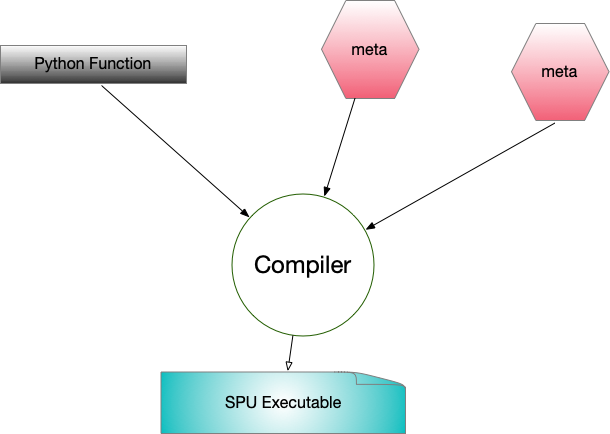



### 步骤2：将SPU可执行文件和秘密分享分配给SPU参与方。

SPU 设备的每一方将获得：

- 一份 SPU Executable
- 每个 SPU object一份share



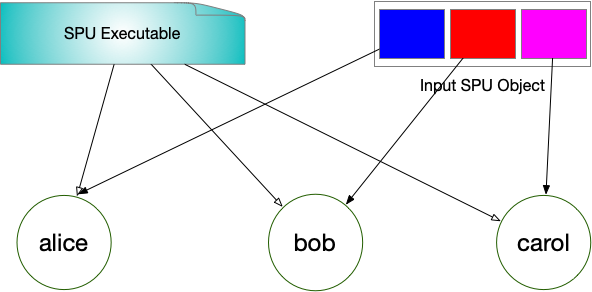



### 步骤3：运行SPU可执行文件并组装SPU对象

然后 SPU 设备的每一方将执行 SPU Executation。

最后，SPU 设备的每一方都将拥有一个输出 SPU Object的一份share和一个meta。

然后 SecretFlow 框架将使用它们来组装 SPU Object。

## 从 SPU 设备中获取值

但最后，我们需要从 spu 中获取值，我们不能总是将 *SPUObject* 当作密文！

处理 *SPUObject* 的最常见方法是将秘密传递给一方。 该方不一定是由 SPU 设备组成的各方之一。

In [ ]:
new_bank_account_pyu = new_bank_account_spu.to(dave)
new_bank_account_pyu
Out [16]:
<secretflow.device.device.pyu.PYUObject at 0x7fd98cd754f0>

我们只是将 *new_bankaccountspu* 传递给 **pyu** ，然后它就变成了 *PYUObject* ！ 它归dave所有。 让我们检查 *new_bank_account_pyu* 的值。

In [ ]:
sf.reveal(new_bank_account_pyu)
Out [17]:
[{'deposit': array(990.25, dtype=float32), 'id': array(12345, dtype=int32)},
 {'deposit': array(99990.25, dtype=float32), 'id': array(12345, dtype=int32)}]

我们也可以直接将 *SPUObject* 传递给host。 利用神奇的 *sf.reveal* 。 再次提醒在生产环境中要小心使用 *sf.reveal* ！

In [ ]:
sf.reveal(new_bank_account_spu)
Out [18]:
[{'deposit': array(990.25, dtype=float32), 'id': array(12345, dtype=int32)},
 {'deposit': array(99990.25, dtype=float32), 'id': array(12345, dtype=int32)}]

## 进阶主题：使用不同的 MPC 协议

目前SPU设备支持ABY3之外的多种MPC协议。 使用不同的 MPC 协议很容易 - 只需在 cluster def 中设置适当的字段。

例如，如果有人想使用 2PC 协议 - Cheetah，你应该准备另一个集群 def：

In [ ]:
import spu
import secretflow as sf
# In case you have a running secretflow runtime already.sf.shutdown()
sf.init(['alice', 'bob', 'carol', 'dave'], address='local')
cheetah_config = sf.utils.testing.cluster_def(    parties=['alice', 'bob'],    runtime_config={        'protocol': spu.spu_pb2.CHEETAH,        'field': spu.spu_pb2.FM64,    },)

然后你可以用 *cheetah_config* 创建一个 SPU 设备。

In [ ]:
spu_device2 = sf.SPU(cheetah_config)

让我们检查一下 spu_device2 的 *cluster_def*。

In [ ]:
spu_device2.cluster_def
Out [21]:
{'nodes': [{'party': 'alice', 'address': '127.0.0.1:64555'},
  {'party': 'bob', 'address': '127.0.0.1:30243'}],
 'runtime_config': {'protocol': 4, 'field': 2}}

我们可以使用 *spu_device2* 来检查著名的姚氏百万富翁问题。

In [ ]:
def get_carol_assets():    return 1000000

def get_dave_assets():    return 1000002

carol, dave = sf.PYU('carol'), sf.PYU('dave')
carol_assets = carol(get_carol_assets)()dave_assets = dave(get_dave_assets)()

我们使用 *spu_device2* 来检查 *carol* 是否更富有。

In [ ]:
def get_winner(carol, dave):    return carol > dave

winner = spu_device2(get_winner)(carol_assets, dave_assets)
sf.reveal(winner)
Out [23]:
array(False)

## 进阶主题：从SPU 计算得到多个返回值

在大多数情况下，我们从 SPU 设备执行的函数中获得多个返回值。

例如，

In [ ]:
def get_multiple_outputs(x, y):

    return x + y, x - y

有多种选择可以处理这个问题。

### 选项 1：将所有返回值视为单一返回值

这是 SPU 的默认行为。 让我们来看看。

In [ ]:
single_output = spu_device2(get_multiple_outputs)(carol_assets, dave_assets)
single_output
Out [25]:
<secretflow.device.device.spu.SPUObject at 0x7fd98cd754c0>

我们可以看到我们只得到一个*SPUObject*。 让我们揭示它。

In [ ]:
sf.reveal(single_output)
Out [26]:
(array(2000002, dtype=int32), array(-2, dtype=int32))

所以 single_output 本身实际上代表一个元组。

### 选项 2：即时决定返回值数量

我们还可以指示 SPU 为我们决定返回值数量。

In [ ]:
from secretflow.device.device.spu import SPUCompilerNumReturnsPolicy
multiple_outputs = spu_device2(    get_multiple_outputs, num_returns_policy=SPUCompilerNumReturnsPolicy.FROM_COMPILER)(carol_assets, dave_assets)
multiple_outputs
Out [27]:
(<secretflow.device.device.spu.SPUObject at 0x7fd98cce0400>,
 <secretflow.device.device.spu.SPUObject at 0x7fd98cce0490>)

让我们分别检查两个输出。

In [ ]:
print(sf.reveal(multiple_outputs[0]))

print(sf.reveal(multiple_outputs[1]))
Out
2000002
-2

### 选项 3：手动确定返回值数量

如果可能，您还可以手动设置返回值数量。

In [ ]:
user_multiple_outputs = spu_device2(    get_multiple_outputs,    num_returns_policy=SPUCompilerNumReturnsPolicy.FROM_USER,    user_specified_num_returns=2,)(carol_assets, dave_assets)
user_multiple_outputs
Out [29]:
[<secretflow.device.device.spu.SPUObject at 0x7fd98cce0a60>,
 <secretflow.device.device.spu.SPUObject at 0x7fd98cce0af0>]

让我们分别检查两个输出。

In [ ]:
print(sf.reveal(multiple_outputs[0]))

print(sf.reveal(multiple_outputs[1]))
Out
2000002
-2

让我们总结一下我们所拥有的结论：

- 默认情况下，SPU 将所有返回值视为单个返回值。
- 由于 SPU 编译器生成 SPU 可执行文件，它可以计算出返回值数量。 但是，这个选项会导致一些延迟，因为我们必须使编译工作阻塞。
- 如果您想避免延迟，我们可以手动提供返回值数量。 但是你必须确保你提供了正确的数字，否则程序会报错！